In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet, get_unet_mod
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from imports.models.losses import bce_dice_loss, dice_coeff, iou
from keras.models import load_model, model_from_json
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/vgg19_80_20/unet_vgg19_80_20.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou':iou,"bce_jaccard_loss":bce_jaccard_loss})

In [97]:
layers = [layer.name for layer in model.layers]
layers

['input_1',
 'd10',
 'd11',
 'max_pooling2d_1',
 'd20',
 'd21',
 'max_pooling2d_2',
 'd30',
 'd31',
 'd32',
 'd33',
 'max_pooling2d_3',
 'd40',
 'd41',
 'd42',
 'd43',
 'max_pooling2d_4',
 'd50',
 'd51',
 'd52',
 'd53',
 'max_pooling2d_5',
 'conv2d_1',
 'batch_normalization_1',
 'up_sampling2d_1',
 'concatenate_1',
 'conv2d_2',
 'batch_normalization_2',
 'conv2d_3',
 'batch_normalization_3',
 'conv2d_4',
 'batch_normalization_4',
 'up_sampling2d_2',
 'concatenate_2',
 'conv2d_5',
 'batch_normalization_5',
 'conv2d_6',
 'batch_normalization_6',
 'conv2d_7',
 'batch_normalization_7',
 'up_sampling2d_3',
 'concatenate_3',
 'conv2d_8',
 'batch_normalization_8',
 'conv2d_9',
 'batch_normalization_9',
 'conv2d_10',
 'batch_normalization_10',
 'up_sampling2d_4',
 'concatenate_4',
 'conv2d_11',
 'batch_normalization_11',
 'conv2d_12',
 'batch_normalization_12',
 'conv2d_13',
 'batch_normalization_13',
 'up_sampling2d_5',
 'concatenate_5',
 'conv2d_14',
 'batch_normalization_14',
 'conv2d_15',


In [6]:
def deprocess_image(img):
    img -= img.mean()
    img /= (img.std()+1e-5)
    img *= 0.1
    
    img += 0.5
    img = np.clip(img,0,1)
    
    img *= 255
    img = np.clip(img,0,255).astype("uint8")
    return img

def generate_pattern(layer_name,filter_index,size=(80,80)):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss,model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)
    iterate = K.function([model.input],[loss,grads])
    loss_value, grads_value = iterate([np.zeros((1,*size,3))])

    input_img_data = np.random.random((1,*size,3))*20.+128.
    step = 1.
    for i in range(50):
        loss_value, grads_value = iterate([np.zeros((1,*size,3))])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

imshow(generate_pattern("conv2d_57",2))

ValueError: No such layer: conv2d_57

In [7]:
shape = (512,768)

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

im = imread(DATA_BASE_PATH+'/00_all/images/img_1000.png')
im = resize(im,shape)
 
def get_intermediate_layer(n_layer,input_shape=(512,768)):
    new_model = Model(input=[model.layers[0].input], output=[model.layers[n_layer].output])
    activations = new_model.predict(im.reshape(1,input_shape[0],input_shape[1],3))
    shape = (activations.shape[1],activations.shape[2])
    n_kernels = activations.shape[3]
    print("Number of Kernels: " + str(n_kernels))
    n_filters = activations.shape[3]
    fig, axs = plt.subplots(ncols=4,nrows=math.ceil(n_kernels/4),figsize=(20,(n_layer//4)*5))
    k = 0
    for i in range(math.ceil(n_kernels/4)):
        for j in range(4):
            axs[i,j].imshow(activations[0,:,:,k].reshape(shape),cmap="YlGn")
            axs[i,j].axis('off')
            axs[i,j].set_title(f"Outputlayer: {n_layer}, Kernel: {k}")
            k += 1
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

Number of Kernels: 128


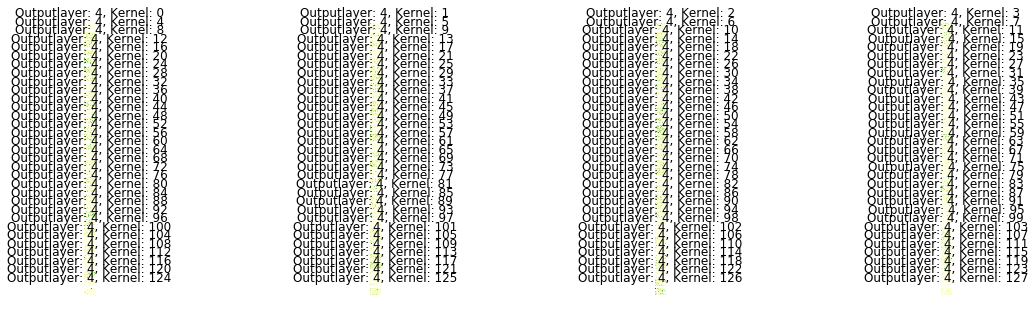

In [11]:
get_intermediate_layer(4)

In [26]:
val20_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
vis_params = {'df':val20_df,
              'input_shape':(512,768,3),
              'pred_layer':1,
              'model':model}

vis = Visualize(**vis_params)

class Layer_Visualization():
    def __init__(self,img):
        self.img = img
        self.model = model
    
    def __deprocess_image(self):
        img -= self.img.mean()
        img /= (img.std()+1e-5)
        img *= 0.1

        img += 0.5
        img = np.clip(img,0,1)

        self.img = img
        
    def __get_activations(self):
        intermediate_model = Model(input=[self.model.layers[0].input], output=[self.model.layers[n_layer].output])
        activation_shape = self.model.layers[n_layer].output_shape[1:3]
        n_kernels = self.model.layers[n_layer].output_shape[3]
        n_x = int(math.sqrt(n_kernels))
        n_y = n_kernels // n_x
        activations = new_model.predict(im.reshape(1,*input_shape,3))

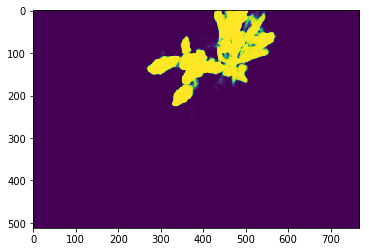

In [41]:
pred = model.predict(img.reshape(1,512,768,3))

imshow(pred[:,:,:,0].reshape(512,768))
#imshow(img)

In [31]:
def deprocess_image(img):
    img -= img.mean()
    img /= (img.std()+1e-5)
    img *= 0.1
    
    img += 0.5
    img = np.clip(img,0,1)
    
    #img *= 255
    #img = np.clip(img,0,255).astype("uint8")
    return img

import math

shape = (512,768)

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

im = vis.get_image(1002)
 
def get_intermediate_layer(n_layer,input_shape=(512,768)):
    new_model = Model(input=[model.layers[0].input], output=[model.layers[n_layer].output])
    activation_shape = model.layers[n_layer].output_shape[1:3]
    n_kernels = model.layers[n_layer].output_shape[3]
    n_x = int(math.sqrt(n_kernels))
    n_y = n_kernels // n_x
    activations = new_model.predict(im.reshape(1,*input_shape,3))
    
    shape = (activations.shape[1],activations.shape[2])
    
    print("Number of Kernels: " + str(n_kernels))
    print((n_y,n_x))
    kernels = activations[0,:,:,0].reshape(activation_shape)
    kernels = np.zeros((n_y*activation_shape[0],n_x*activation_shape[1]))
    print(kernels.shape)
    print(shape)
    k = 0
    for y in range(n_y):
        for x in range(n_x):
            act = activations[0,:,:,k]
            kernels[y*shape[0]:(y+1)*shape[0],x*shape[1]:(x+1)*shape[1]] = deprocess_image(act)
            k += 1
           
    plt.figure(figsize=(15,15))
    imsave("kernels.png",kernels)
    imshow(kernels)
    print(kernels.max())
    #imshow(np.median(activations,axis=3).reshape(32,48))
    med = np.median(activations,axis=3).reshape(shape)
    med = resize(med,(512,768))
    imsave("median.png",med)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
d10 (Conv2D)                    (None, 512, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
d11 (Conv2D)                    (None, 512, 768, 64) 36928       d10[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 384, 64) 0           d11[0][0]                        
__________________________________________________________________________________________________
d20 (Conv2

In [219]:
import cv2 as cv

def deprocess_image(img):
    img -= img.mean()
    img /= (img.std()+1e-5)
    img *= 0.1
    
    img += 0.5
    img = np.clip(img,0,1)
    return img

def add_median(input_shape=(512,768)):
    int_images = []
    
    font = cv.FONT_HERSHEY_SIMPLEX

    for ind,l in enumerate(model.layers):
        if ind == 0:
            continue
        new_model = Model(input=[model.layers[0].input], output=[model.layers[ind].output])
        activation_shape = model.layers[ind].output_shape[1:3]
        n_kernels = model.layers[ind].output_shape[3]
        n_x = int(math.sqrt(n_kernels))
        n_y = n_kernels // n_x
        activations = new_model.predict(im.reshape(1,*input_shape,3))

        shape = (activations.shape[1],activations.shape[2])
        kernels = activations[0,:,:,0].reshape(activation_shape)
        kernels = np.zeros((n_y*activation_shape[0],n_x*activation_shape[1]))
        #imshow(np.median(activations,axis=3).reshape(32,48))
        med = np.mean(activations,axis=3).reshape(shape)
        med = resize(med,(512,768))
        med = deprocess_image(med)
        text = np.zeros((50,768))
        text = cv.putText(text, str(model.layers[ind].name), (20, 35), font, 1, (220, 20, 20), 2, cv.LINE_AA)
        text = deprocess_image(text)
        med = np.vstack((text,med))
        
        int_images.append(med)
        
    return int_images

In [220]:
images = add_median()

In [221]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [222]:
def f(x):
    plt.figure(figsize=(10,10))
    imshow(images[x])
interact(f, x=(0,len(images)-1))

interactive(children=(IntSlider(value=32, description='x', max=64), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [162]:
def save_median(n_layers,input_shape=(512,768)):
    for ind,l in enumerate(n_layers):
        new_model = Model(input=[model.layers[0].input], output=[model.layers[l].output])
        activation_shape = model.layers[l].output_shape[1:3]
        n_kernels = model.layers[l].output_shape[3]
        n_x = int(math.sqrt(n_kernels))
        n_y = n_kernels // n_x
        activations = new_model.predict(im.reshape(1,*input_shape,3))

        shape = (activations.shape[1],activations.shape[2])
        kernels = activations[0,:,:,0].reshape(activation_shape)
        kernels = np.zeros((n_y*activation_shape[0],n_x*activation_shape[1]))
        #imshow(np.median(activations,axis=3).reshape(32,48))
        med = np.mean(activations,axis=3).reshape(shape)
        med = resize(med,(512,768))
        name = "learning/" + str(l) + ".png"
        imsave(name,med)

In [56]:
save_median([3,6,11,16,21,23,25,30,33,36,39,42,45,48,51,54,57,60,63,65])

In [58]:
name = "learning/" + "0" + ".png"
imsave(name,img)

pred = model.predict(img.reshape(1,512,768,3))

name = "learning/" + "70" + ".png"
imsave(name,pred[:,:,:,1].reshape(512,768))

name = "learning/" + "80" + ".png"
imsave(name,pred[:,:,:,0].reshape(512,768))

Number of Kernels: 128
(11, 11)
(1408, 2112)
(128, 192)
1.0


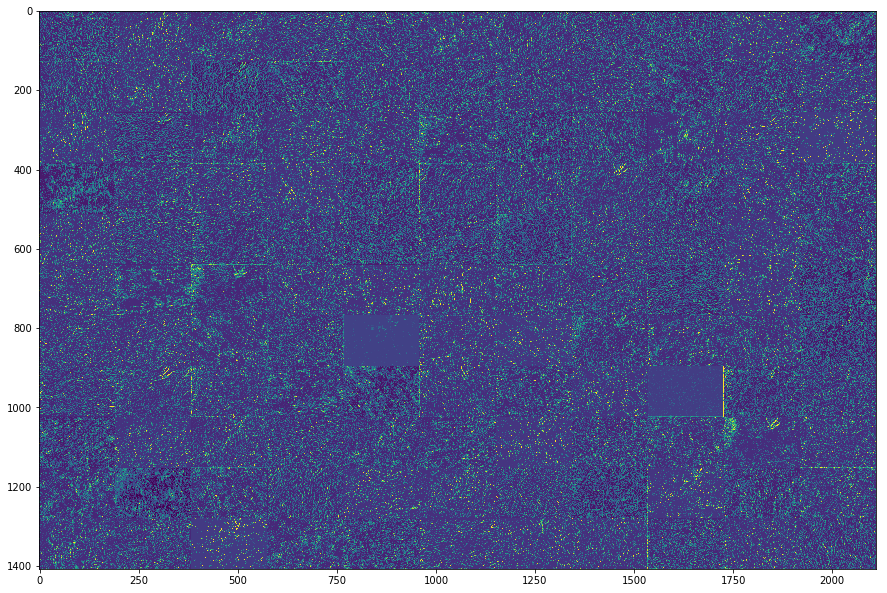

In [42]:
get_intermediate_layer(6)